In [1]:
import json
import pandas as pd
from pathlib import Path
from pprint import pprint
import datetime
import time
import numpy as np
import matplotlib as plt

import pandas
import researchpy as rp
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

%matplotlib inline

In [2]:
#path_results = Path('/media/discoD/models/elmo/ner/datalawyer')
path_results = Path('/opt/models/elmo/ner/results/')
#path_results = Path('/opt/models/elmo/ner/results_datalawyer_jur/')

In [3]:
for folder in path_results.iterdir():
    print(folder)

/opt/models/elmo/ner/results/datalawyer


In [4]:
configs = dict()
metrics = dict()
for folder in path_results.iterdir():
    if folder.is_dir():
        results_model_folder = folder.iterdir()
        for training_folder in results_model_folder:
            #print('Reading files from %s' % training_folder.name)
            has_metrics = False
            for results_file in training_folder.iterdir():
                if results_file.name.endswith('.json'):
                    #print('Parsing data from %s' % results_file.name)
                    if results_file.name.startswith('config'):
                        configs[training_folder.name] = json.loads(results_file.read_bytes())
                    elif results_file.name.startswith('metrics.'):
                        metrics[training_folder.name] = json.loads(results_file.read_bytes())
                        has_metrics = True
            if not has_metrics:
                print('metrics.json not found for %s' % training_folder.name)
                del configs[training_folder.name]
print(len(metrics))
print(len(configs))

45
45


In [5]:
def get_seconds(time_str):
    x = time.strptime(time_str,'%H:%M:%S')
    return datetime.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds()
def get_average_epoch_duration(metrics):
    seconds = get_seconds(metrics['training_duration'])
    training_epochs = metrics['training_epochs'] + 1
    return seconds / training_epochs

In [6]:
TRAINING_ID = 'Training_ID'
SCENARIO = 'Scenario'
MODEL = 'Model'
EMBEDDING = 'Embedding'
EMBEDDING_TYPE = 'Embedding_Type'
DOMAN_SPECIFIC = 'Domain_Specific'
BATCH_SIZE = 'Batch_Size'
ELMO_DROPOUT = 'ELMo_Dropout'
TRAINING_NUMBER = 'Training_Number'
EXECUTION_NUMBER = 'Execution_Number'
BEST_EPOCH = 'Best_Epoch'
TRAINING_EPOCHS = 'Training_Epochs'
TRAINING_DURATION = 'Training_Duration'
TOTAL_DURATION = 'Total_Duration(s)'
AVERAGE_EPOCH_DURATION = 'Average_Epoch_Duration(s)'
TRAINING_ACCURACY = 'Training_Accuracy'
TRAINING_ACCURACY_TOP3 = 'Training_Accuracy_Top-3'
TRAINING_PRECISION = 'Training_Precision'
TRAINING_RECALL = 'Training_Recall'
TRAINING_F1_MEASURE = 'Training_F1-Measure'
TRAINING_LOSS = 'Training_Loss'
BEST_VALIDATION_ACCURACY = 'Best_Validation_Accuracy'
BEST_VALIDATION_ACCURACY_TOP3 = 'Best_Validation_Accuracy_Top-3'
BEST_VALIDATION_PRECISION = 'Best_Validation_Precision'
BEST_VALIDATION_RECALL = 'Best_Validation_Recall'
BEST_VALIDATION_F1_MEASURE = 'Best_Validation_F1-Measure'
BEST_VALIDATION_LOSS = 'Best_Validation_Loss'
TEST_ACCURACY = 'Test_Accuracy'
TEST_ACCURACY_TOP3 = 'Test_Accuracy_Top-3'
TEST_PRECISION = 'Test_Precision'
TEST_RECALL = 'Test_Recall'
TEST_F1_MEASURE = 'Test_F1_Measure'
TEST_LOSS = 'Test_Loss'
columns = [TRAINING_ID, MODEL, EMBEDDING, DOMAN_SPECIFIC, EMBEDDING_TYPE, TRAINING_NUMBER, EXECUTION_NUMBER, BEST_EPOCH, TRAINING_EPOCHS, TRAINING_DURATION, TOTAL_DURATION, AVERAGE_EPOCH_DURATION, TRAINING_ACCURACY, TRAINING_ACCURACY_TOP3, TRAINING_PRECISION, TRAINING_RECALL, TRAINING_F1_MEASURE, TRAINING_LOSS, BEST_VALIDATION_ACCURACY, BEST_VALIDATION_ACCURACY_TOP3, BEST_VALIDATION_PRECISION, BEST_VALIDATION_RECALL, BEST_VALIDATION_F1_MEASURE, BEST_VALIDATION_LOSS, TEST_ACCURACY, TEST_ACCURACY_TOP3, TEST_PRECISION, TEST_RECALL, TEST_F1_MEASURE, TEST_LOSS]
columns

['Training_ID',
 'Model',
 'Embedding',
 'Domain_Specific',
 'Embedding_Type',
 'Training_Number',
 'Execution_Number',
 'Best_Epoch',
 'Training_Epochs',
 'Training_Duration',
 'Total_Duration(s)',
 'Average_Epoch_Duration(s)',
 'Training_Accuracy',
 'Training_Accuracy_Top-3',
 'Training_Precision',
 'Training_Recall',
 'Training_F1-Measure',
 'Training_Loss',
 'Best_Validation_Accuracy',
 'Best_Validation_Accuracy_Top-3',
 'Best_Validation_Precision',
 'Best_Validation_Recall',
 'Best_Validation_F1-Measure',
 'Best_Validation_Loss',
 'Test_Accuracy',
 'Test_Accuracy_Top-3',
 'Test_Precision',
 'Test_Recall',
 'Test_F1_Measure',
 'Test_Loss']

In [7]:
def get_training_data_from_id(training_id, config):
    data = training_id.split('_')
    print(data)
    if len(data) == 4:
        return {MODEL: data[0], EMBEDDING: data[1], DOMAN_SPECIFIC: False, EMBEDDING_TYPE: 'No', TRAINING_NUMBER: data[2], EXECUTION_NUMBER: data[3]}
    elif len(data) == 5:
        embedding_type = 'No' if data[1] == 'glove' else data[2]
        domain_specific = data[2] == 'jur'
        return {MODEL: data[0], EMBEDDING: data[1], DOMAN_SPECIFIC: domain_specific, EMBEDDING_TYPE: embedding_type, TRAINING_NUMBER: data[3], EXECUTION_NUMBER: data[4]}
    elif len(data) == 6:
        return {MODEL: data[0], EMBEDDING: data[1], DOMAN_SPECIFIC: True, EMBEDDING_TYPE: data[2], TRAINING_NUMBER: data[4], EXECUTION_NUMBER: data[5]}
    else:
        print('Invalid id: %s' % training_id)

In [8]:
training_data = []
for training_id, config in configs.items():
    training_metrics = metrics[training_id]
    data = get_training_data_from_id(training_id, config)
    data[TRAINING_ID] = training_id
    data[BEST_EPOCH] = training_metrics['best_epoch'] if training_metrics else None
    data[TRAINING_EPOCHS] = training_metrics['training_epochs'] + 1 if training_metrics else None
    data[TRAINING_DURATION] = training_metrics['training_duration'] if training_metrics else None
    data[TOTAL_DURATION] = get_seconds(training_metrics['training_duration']) if training_metrics else None
    data[AVERAGE_EPOCH_DURATION] = get_average_epoch_duration(training_metrics) if training_metrics else None
    data[TRAINING_ACCURACY] = training_metrics['training_accuracy'] if training_metrics else None
    data[TRAINING_ACCURACY_TOP3] = training_metrics['training_accuracy3'] if training_metrics else None
    data[TRAINING_PRECISION] = training_metrics['training_precision-overall'] if training_metrics else None
    data[TRAINING_RECALL] = training_metrics['training_recall-overall'] if training_metrics else None
    data[TRAINING_F1_MEASURE] = training_metrics['training_f1-measure-overall'] if training_metrics else None
    data[TRAINING_LOSS] = training_metrics['training_loss'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY] = training_metrics['best_validation_accuracy'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY_TOP3] = training_metrics['best_validation_accuracy3'] if training_metrics else None
    data[BEST_VALIDATION_PRECISION] = training_metrics['best_validation_precision-overall'] if training_metrics else None
    data[BEST_VALIDATION_RECALL] = training_metrics['best_validation_recall-overall'] if training_metrics else None
    data[BEST_VALIDATION_F1_MEASURE] = training_metrics['best_validation_f1-measure-overall'] if training_metrics else None
    data[BEST_VALIDATION_LOSS] = training_metrics['best_validation_loss'] if training_metrics else None
    data[TEST_ACCURACY] = training_metrics['test_accuracy'] if training_metrics else None
    data[TEST_ACCURACY_TOP3] = training_metrics['test_accuracy3'] if training_metrics else None
    data[TEST_PRECISION] = training_metrics['test_precision-overall'] if training_metrics else None
    data[TEST_RECALL] = training_metrics['test_recall-overall'] if training_metrics else None
    data[TEST_F1_MEASURE] = training_metrics['test_f1-measure-overall'] if training_metrics else None
    data[TEST_LOSS] = training_metrics['test_loss'] if training_metrics else None
    training_data.append(data)

['datalawyer', 'word2vec', 'cbow', 'jur', '0', '1']
['datalawyer', 'wang2vec', 'cbow', 'jur', '0', '1']
['datalawyer', 'fasttext', 'cbow', 'jur', '0', '0']
['datalawyer', 'wang2vec', 'cbow', 'jur', '0', '2']
['datalawyer', 'wang2vec', 'cbow', '0', '1']
['datalawyer', 'none', '0', '2']
['datalawyer', 'fasttext', 'skip', 'jur', '0', '1']
['datalawyer', 'wang2vec', 'skip', 'jur', '0', '0']
['datalawyer', 'fasttext', 'cbow', 'jur', '0', '2']
['datalawyer', 'fasttext', 'skip', '0', '1']
['datalawyer', 'fasttext', 'cbow', '0', '1']
['datalawyer', 'glove', 'jur', '0', '1']
['datalawyer', 'fasttext', 'skip', '0', '0']
['datalawyer', 'word2vec', 'skip', '0', '2']
['datalawyer', 'fasttext', 'skip', '0', '2']
['datalawyer', 'glove', '0', '1']
['datalawyer', 'word2vec', 'cbow', '0', '2']
['datalawyer', 'wang2vec', 'skip', '0', '0']
['datalawyer', 'fasttext', 'skip', 'jur', '0', '2']
['datalawyer', 'word2vec', 'cbow', 'jur', '0', '0']
['datalawyer', 'glove', 'jur', '0', '0']
['datalawyer', 'none', 

In [9]:
pd.set_option('display.max_columns', 1000)
training_data_df = pd.DataFrame(training_data, columns=columns)
training_data_df

,Training_ID,Model,Embedding,Domain_Specific,Embedding_Type,Training_Number,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss
0,datalawyer_word2vec_cbow_jur_0_1,datalawyer,word2vec,True,cbow,0,1,17,20,01:24:23,5063.0,253.15,0.994144,0.994425,0.932120,0.928163,0.930137,9.268986,0.988533,0.988884,0.886057,0.890060,0.888054,27.760028,0.986411,0.986904,0.860248,0.868339,0.864275,36.605772
1,datalawyer_wang2vec_cbow_jur_0_1,datalawyer,wang2vec,True,cbow,0,1,14,20,01:20:30,4830.0,241.50,0.996527,0.996653,0.959297,0.961959,0.960626,6.110496,0.988477,0.988866,0.889561,0.885542,0.887547,31.869278,0.985777,0.986358,0.851130,0.855799,0.853458,43.884615
2,datalawyer_fasttext_cbow_jur_0_0,datalawyer,fasttext,True,cbow,0,0,18,20,01:22:29,4949.0,247.45,0.991647,0.992027,0.909808,0.904163,0.906977,11.956467,0.988514,0.988755,0.892400,0.893072,0.892736,22.394122,0.986763,0.987115,0.863287,0.880878,0.871994,28.708887
3,datalawyer_wang2vec_cbow_jur_0_2,datalawyer,wang2vec,True,cbow,0,2,11,20,01:25:30,5130.0,256.50,0.996358,0.996523,0.957818,0.960163,0.958989,5.983225,0.988810,0.989217,0.889728,0.887048,0.888386,34.251978,0.986094,0.986657,0.853375,0.862069,0.857700,44.453846
4,datalawyer_wang2vec_cbow_0_1,datalawyer,wang2vec,False,cbow,0,1,10,20,01:21:49,4909.0,245.45,0.996592,0.996711,0.958205,0.961959,0.960078,5.827168,0.986813,0.987146,0.885049,0.887048,0.886047,31.319357,0.985918,0.986464,0.845329,0.865204,0.855151,39.251624
5,datalawyer_none_0_2,datalawyer,none,False,No,0,2,9,20,01:24:07,5047.0,252.35,0.995712,0.995908,0.951475,0.947592,0.949530,7.345082,0.987848,0.988144,0.881481,0.896084,0.888723,30.093626,0.986921,0.987467,0.846861,0.866771,0.856700,37.614259
6,datalawyer_fasttext_skip_jur_0_1,datalawyer,fasttext,True,skip,0,1,18,20,01:22:33,4953.0,247.65,0.996035,0.996223,0.952226,0.953469,0.952847,6.736282,0.987220,0.987497,0.883546,0.885542,0.884543,36.519183,0.986745,0.987238,0.857692,0.873824,0.865683,42.950205
7,datalawyer_wang2vec_skip_jur_0_0,datalawyer,wang2vec,True,skip,0,0,17,20,01:21:32,4892.0,244.60,0.995908,0.996050,0.953143,0.953143,0.953143,6.226970,0.988144,0.988477,0.876364,0.907380,0.891602,35.220744,0.985865,0.986323,0.831469,0.873824,0.852121,46.452001
8,datalawyer_fasttext_cbow_jur_0_2,datalawyer,fasttext,True,cbow,0,2,17,20,01:27:37,5257.0,262.85,0.991774,0.992112,0.914290,0.910857,0.912571,12.188687,0.987423,0.987737,0.865994,0.905120,0.885125,24.333945,0.985584,0.986059,0.840418,0.883229,0.861292,30.727911
9,datalawyer_fasttext_skip_0_1,datalawyer,fasttext,False,skip,0,1,17,20,01:24:26,5066.0,253.30,0.996419,0.996600,0.959177,0.959020,0.959099,5.761095,0.988570,0.988847,0.880531,0.899096,0.889717,36.451913,0.986816,0.987273,0.848554,0.873824,0.861004,45.238228


In [10]:
training_data_df.to_csv('training_data_20_epochs_mestrado_datalawyer.csv', index=None)

In [11]:
str(datetime.timedelta(seconds=training_data_df[TOTAL_DURATION].mean()))

'1:23:44.933333'

In [12]:
training_data_df.groupby([EMBEDDING_TYPE]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding_Type,,,,,,,,
cbow,18.0,0.859661,0.006107,0.845306,0.856393,0.859071,0.862722,0.871994
No,9.0,0.856519,0.006693,0.845416,0.851983,0.856700,0.862592,0.864865
skip,18.0,0.856472,0.005359,0.846419,0.852472,0.856640,0.860497,0.865683


In [13]:
training_data_df.groupby([EMBEDDING]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding,,,,,,,,
fasttext,12.0,0.860349,0.007532,0.845306,0.856918,0.860401,0.865767,0.871994
word2vec,12.0,0.857370,0.004882,0.848578,0.855316,0.857031,0.860355,0.864760
glove,6.0,0.856948,0.005732,0.850174,0.852315,0.857158,0.862195,0.862622
wang2vec,12.0,0.856482,0.004564,0.846419,0.854300,0.856972,0.859948,0.863100
none,3.0,0.855660,0.009766,0.845416,0.851058,0.856700,0.860783,0.864865


In [14]:
training_data_df.groupby([EMBEDDING, EMBEDDING_TYPE]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,,count,mean,std,min,25%,50%,75%,max
Embedding,Embedding_Type,,,,,,,,
fasttext,cbow,6.0,0.862280,0.009538,0.845306,0.860075,0.863655,0.868553,0.871994
word2vec,cbow,6.0,0.858922,0.003344,0.855912,0.856393,0.857808,0.860808,0.864275
fasttext,skip,6.0,0.858418,0.004988,0.851080,0.856021,0.858582,0.860703,0.865683
wang2vec,cbow,6.0,0.857783,0.003395,0.853458,0.855759,0.857642,0.859203,0.863100
glove,No,6.0,0.856948,0.005732,0.850174,0.852315,0.857158,0.862195,0.862622
word2vec,skip,6.0,0.855818,0.005956,0.848578,0.851766,0.855224,0.859189,0.864760
none,No,3.0,0.855660,0.009766,0.845416,0.851058,0.856700,0.860783,0.864865
wang2vec,skip,6.0,0.855181,0.005498,0.846419,0.852736,0.855470,0.859601,0.860927


In [15]:
training_data_df.groupby([EMBEDDING, DOMAN_SPECIFIC]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,,count,mean,std,min,25%,50%,75%,max
Embedding,Domain_Specific,,,,,,,,
fasttext,True,6.0,0.864255,0.005735,0.857366,0.860172,0.863487,0.868469,0.871994
glove,True,3.0,0.858970,0.004963,0.853313,0.857158,0.861004,0.861798,0.862592
word2vec,False,6.0,0.858142,0.004181,0.853528,0.855970,0.856531,0.860420,0.864760
wang2vec,True,6.0,0.856671,0.003390,0.852121,0.854184,0.857030,0.859203,0.860681
word2vec,True,6.0,0.856599,0.005790,0.848578,0.852670,0.857808,0.859577,0.864275
fasttext,False,6.0,0.856442,0.007436,0.845306,0.852203,0.857621,0.860670,0.866019
wang2vec,False,6.0,0.856294,0.005852,0.846419,0.854723,0.856367,0.860091,0.863100
none,False,3.0,0.855660,0.009766,0.845416,0.851058,0.856700,0.860783,0.864865
glove,False,3.0,0.854926,0.006726,0.850174,0.851078,0.851983,0.857303,0.862622


In [16]:
training_data_df.groupby([EMBEDDING, EMBEDDING_TYPE, DOMAN_SPECIFIC]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

count      mean       std       min  \
Embedding Embedding_Type Domain_Specific                                        
fasttext  cbow           True               3.0  0.867561  0.005582  0.861292   
          skip           True               3.0  0.860949  0.004276  0.857366   
word2vec  cbow           True               3.0  0.859963  0.003792  0.857143   
glove     No             True               3.0  0.858970  0.004963  0.853313   
wang2vec  cbow           False              3.0  0.858612  0.004073  0.855151   
word2vec  skip           False              3.0  0.858403  0.005761  0.853528   
          cbow           False              3.0  0.857881  0.003211  0.855912   
fasttext  cbow           False              3.0  0.856998  0.010612  0.845306   
wang2vec  cbow           True               3.0  0.856954  0.003189  0.853458   
          skip           True               3.0  0.856387  0.004280  0.852121   
fasttext  skip           False              3.0  0.855886  0.004969  0.851080   
none      No             False              3.0  0.855660  0.009766  0.845416   
glove     No             False              3.0  0.854926  0.006726  0.850174   
wang2vec  skip           False              3.0  0.853976  0.007273  0.846419   
word2vec  skip           True               3.0  0.853234  0.005956  0.848578   

                                               25%       50%       75%  \
Embedding Embedding_Type Domain_Specific                                 
fasttext  cbow           True             0.865344  0.869397  0.870696   
          skip           True             0.858582  0.859799  0.862741   
word2vec  cbow           True             0.857808  0.858472  0.861373   
glove     No             True             0.857158  0.861004  0.861798   
wang2vec  cbow           False            0.856367  0.857584  0.860342   
word2vec  skip           False            0.855224  0.856919  0.860840   
          cbow           False            0.856028  0.856143  0.858865   
fasttext  cbow           False            0.852488  0.859669  0.862844   
wang2vec  cbow           True             0.855579  0.857700  0.858702   
          skip           True             0.854240  0.856360  0.858521   
fasttext  skip           False            0.853327  0.855573  0.858288   
none      No             False            0.851058  0.856700  0.860783   
glove     No             False            0.851078  0.851983  0.857303   
wang2vec  skip           False            0.850500  0.854581  0.857754   
word2vec  skip           True             0.849878  0.851179  0.855562   

                                               max  
Embedding Embedding_Type Domain_Specific            
fasttext  cbow           True             0.871994  
          skip           True             0.865683  
word2vec  cbow           True             0.864275  
glove     No             True             0.862592  
wang2vec  cbow           False            0.863100  
word2vec  skip           False            0.864760  
          cbow           False            0.861586  
fasttext  cbow           False            0.866019  
wang2vec  cbow           True             0.859704  
          skip           True             0.860681  
fasttext  skip           False            0.861004  
none      No             False            0.864865  
glove     No             False            0.862622  
wang2vec  skip           False            0.860927  
word2vec  skip           True             0.859945

In [27]:
training_data_df[training_data_df[DOMAN_SPECIFIC] == True].groupby([EMBEDDING, EMBEDDING_TYPE]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

count      mean       std       min       25%  \
Embedding Embedding_Type                                                  
fasttext  cbow              3.0  0.867561  0.005582  0.861292  0.865344   
          skip              3.0  0.860949  0.004276  0.857366  0.858582   
word2vec  cbow              3.0  0.859963  0.003792  0.857143  0.857808   
glove     No                3.0  0.858970  0.004963  0.853313  0.857158   
wang2vec  cbow              3.0  0.856954  0.003189  0.853458  0.855579   
          skip              3.0  0.856387  0.004280  0.852121  0.854240   
word2vec  skip              3.0  0.853234  0.005956  0.848578  0.849878   

                               50%       75%       max  
Embedding Embedding_Type                                
fasttext  cbow            0.869397  0.870696  0.871994  
          skip            0.859799  0.862741  0.865683  
word2vec  cbow            0.858472  0.861373  0.864275  
glove     No              0.861004  0.861798  0.862592  
wang2vec  cbow            0.857700  0.858702  0.859704  
          skip            0.856360  0.858521  0.860681  
word2vec  skip            0.851179  0.855562  0.859945

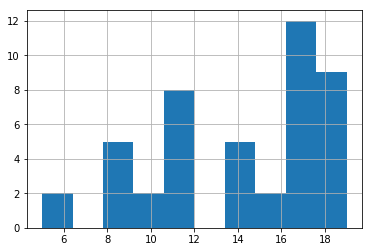

In [17]:
training_data_df[BEST_EPOCH].hist()

In [18]:
training_data_df[TOTAL_DURATION].describe()

count      45.000000
mean     5024.933333
std       171.661718
min      4787.000000
25%      4892.000000
50%      5001.000000
75%      5130.000000
max      5464.000000
Name: Total_Duration(s), dtype: float64

In [19]:
training_data_df.groupby([TRAINING_NUMBER]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Training_Number,,,,,,,,
0,45.0,0.857757,0.00601,0.845306,0.853528,0.857584,0.861292,0.871994


In [20]:
rp.summary_cont(training_data_df[TEST_F1_MEASURE])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Test_F1_Measure,45.0,0.857757,0.00601,0.000896,0.855952,0.859563


In [21]:
rp.summary_cont(training_data_df.groupby(MODEL))[TEST_F1_MEASURE]

,N,Mean,SD,SE,95% Conf.,Interval
Model,,,,,,
datalawyer,45,0.857757,0.00601,0.000896,0.856001,0.859513


In [22]:
rp.summary_cont(training_data_df.groupby(EMBEDDING))[TEST_F1_MEASURE]

,N,Mean,SD,SE,95% Conf.,Interval
Embedding,,,,,,
fasttext,12,0.860349,0.007532,0.002174,0.856087,0.864610
glove,6,0.856948,0.005732,0.002340,0.852362,0.861534
none,3,0.855660,0.009766,0.005638,0.844609,0.866712
wang2vec,12,0.856482,0.004564,0.001317,0.853900,0.859064
word2vec,12,0.857370,0.004882,0.001409,0.854608,0.860132


In [23]:
rp.summary_cont(training_data_df.groupby([MODEL,EMBEDDING]))[TEST_F1_MEASURE]

N      Mean        SD        SE  95% Conf.  Interval
Model      Embedding                                                       
datalawyer fasttext   12  0.860349  0.007532  0.002174   0.856087  0.864610
           glove       6  0.856948  0.005732  0.002340   0.852362  0.861534
           none        3  0.855660  0.009766  0.005638   0.844609  0.866712
           wang2vec   12  0.856482  0.004564  0.001317   0.853900  0.859064
           word2vec   12  0.857370  0.004882  0.001409   0.854608  0.860132

In [24]:
print(TEST_F1_MEASURE, MODEL, EMBEDDING, BATCH_SIZE, ELMO_DROPOUT)

Test_F1_Measure Model Embedding Batch_Size ELMo_Dropout


In [25]:
# Calculating effect size
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    
    cols = ['sum_sq', 'mean_sq', 'df', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

def print_anova(parameter):
    # Fits the model with the interaction term
    # This will also automatically include the main effects for each factor
    model = ols('Test_F1_Measure ~ C({0})'.format(parameter), training_data_df).fit()
    # Seeing if the overall model is significant
    print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .20f}")
    print(model.summary())
    res = sm.stats.anova_lm(model, typ= 2)
    print(res)
    print(anova_table(res))
    mc = statsmodels.stats.multicomp.MultiComparison(training_data_df[TEST_F1_MEASURE], training_data_df[parameter])
    mc_results = mc.tukeyhsd()
    print(mc_results)

In [26]:
print_anova(EMBEDDING)

Overall model F( 4, 40) =  0.809, p =  0.52663662353460638510
                            OLS Regression Results                            
Dep. Variable:        Test_F1_Measure   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                 -0.018
Method:                 Least Squares   F-statistic:                    0.8094
Date:                Fri, 24 May 2019   Prob (F-statistic):              0.527
Time:                        13:28:46   Log-Likelihood:                 168.55
No. Observations:                  45   AIC:                            -327.1
Df Residuals:                      40   BIC:                            -318.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------